# Imports

In [30]:
import os
import sys
import math
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_origin
import fiona
import pandas as pd
import geopandas as gpd
from rasterio import features
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from scipy.ndimage import distance_transform_edt


In [31]:
# Get the current working directory
current_dir = os.path.abspath('')

# Search for the 'constants.py' file starting from the current directory and moving up the hierarchy
project_root = current_dir
while not os.path.isfile(os.path.join(project_root, 'constants.py')):
    project_root = os.path.dirname(project_root)

# Add the project root to the Python path
sys.path.append(project_root)

In [32]:
from constants import TREECOVER_2010, OUTPUT_PATH, ROAD_PATH , RIVER_PATH

# Pixel Distance to Nearest Road

Here we determine the distance to Roads and Rivers within the land use plans.

<Axes: >

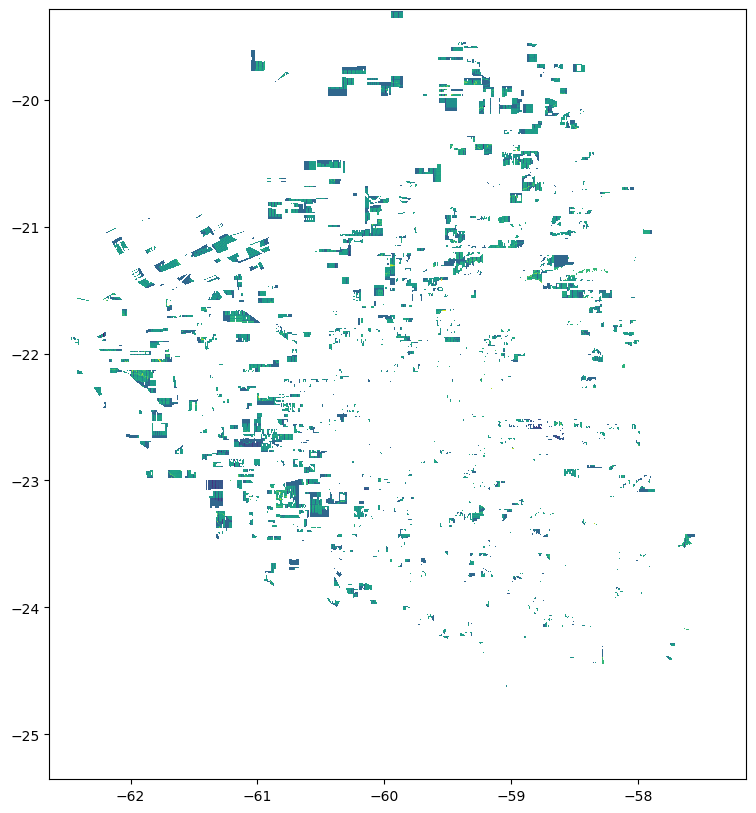

In [48]:
lup_raster = rasterio.open('/Users/romero61/../../capstone/pyforest/ml_data/output/masked_rasters/lup_10_masked.tif')
# Read the raster data into a NumPy array
lup_raster_array = lup_raster.read(1)
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(lup_raster, ax = ax)
plt.gca()

In [36]:
# Read in vector
vector = gpd.read_file(ROAD_PATH[0]).to_crs("EPSG:4326")

# Get list of geometries for all features in vector file
geom = [shapes for shapes in vector.geometry]



<Axes: >

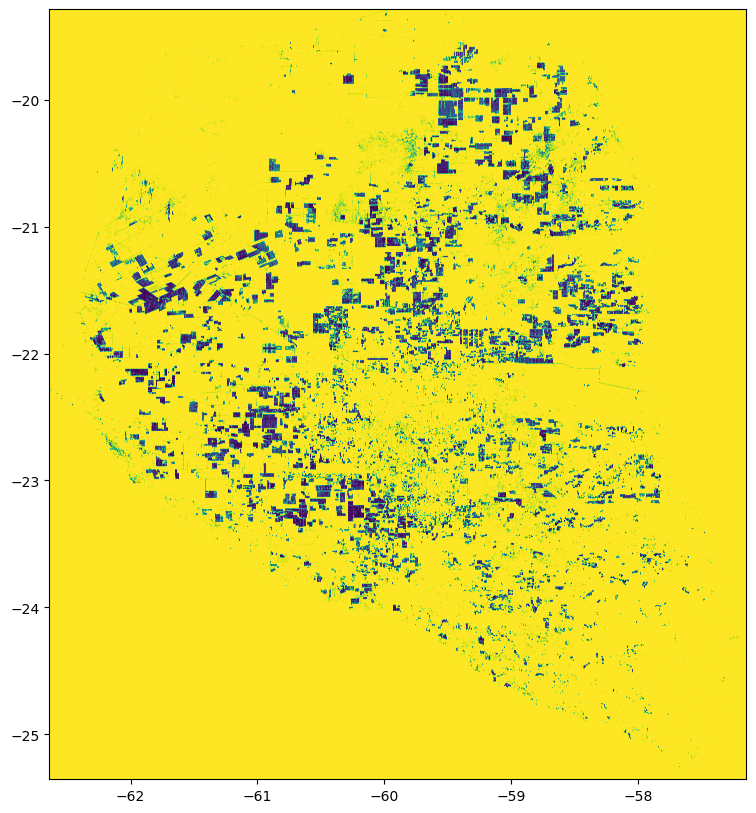

In [37]:
# Open example raster
raster = rasterio.open(TREECOVER_2010)

# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(raster, ax = ax)
plt.gca()

In [38]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized = features.rasterize(geom,
                                out_shape = raster.shape,
                                fill = -1,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)



<Axes: >

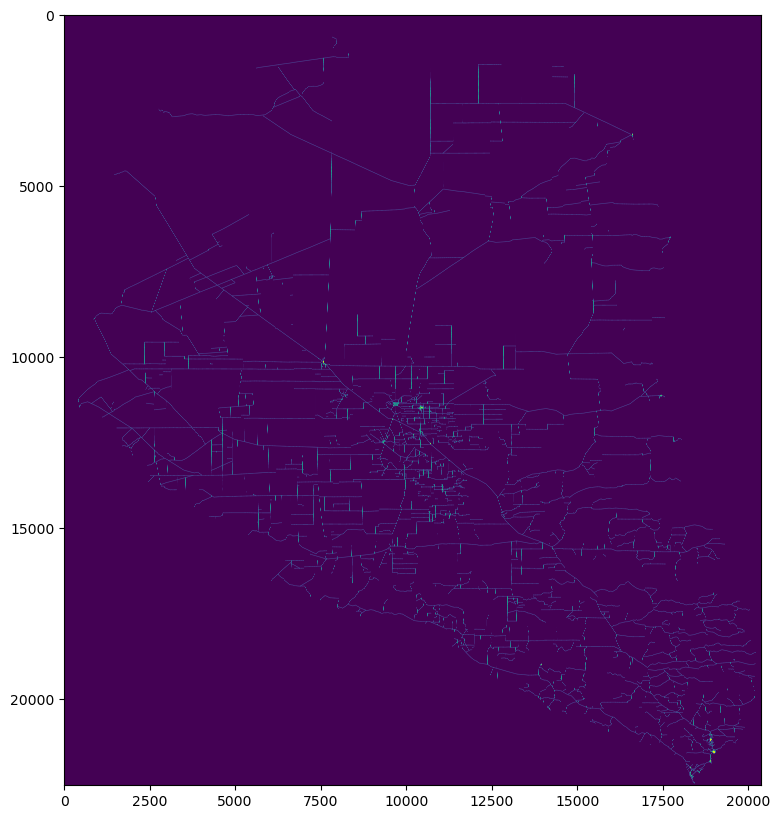

In [39]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized, ax = ax)
plt.gca()

In [49]:
# Convert the rasterized array to boolean where True represents roads
road_mask = rasterized == 1

# Convert the lup_raster array to boolean where True represents the area of interest
area_mask = np.isin(lup_raster_array, [1, 2, 3, 4])

# Calculate the Euclidean distance from each road pixel to every other pixel
distances = distance_transform_edt(~road_mask)

# For pixels outside the area of interest, set the distance to a nodata value
distances[~area_mask] = -1



In [24]:
raster.profile


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'tiled': False, 'interleave': 'band'}

In [50]:
# Modify the nodata value and the data type in the raster profile
profile = raster.profile
profile.update(nodata=-1, dtype='float32')

profile


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'tiled': False, 'interleave': 'band'}

In [51]:
# Where files will save, can add subfolders if desired
output_dir = os.path.join(OUTPUT_PATH[0], 'processed_rasters', 'road_raster')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'road_raster.tif')


In [52]:


# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(distances.astype('float32'), 1)



# Pixel Distance to Nearest River

In [6]:
# Modify the nodata value and the data type in the raster profile
profile = raster.profile
profile.update(nodata=-1, dtype='float32')

profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1, 'width': 20381, 'height': 22512, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -62.64186038139295,
       0.0, -0.00026949458523585647, -19.287457970745013), 'tiled': False, 'interleave': 'band'}

In [7]:
# Read in vector
vector_river = gpd.read_file(RIVER_PATH[0]).to_crs("EPSG:4326")

# Get list of geometries for all features in vector file
geom_river = [shapes for shapes in vector_river.geometry]


In [8]:
# Rasterize vector using the shape and coordinate system of the raster
rasterized_river = features.rasterize(geom_river,
                                out_shape = raster.shape,
                                fill = -1,
                                out = None,
                                transform = raster.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

<Axes: >

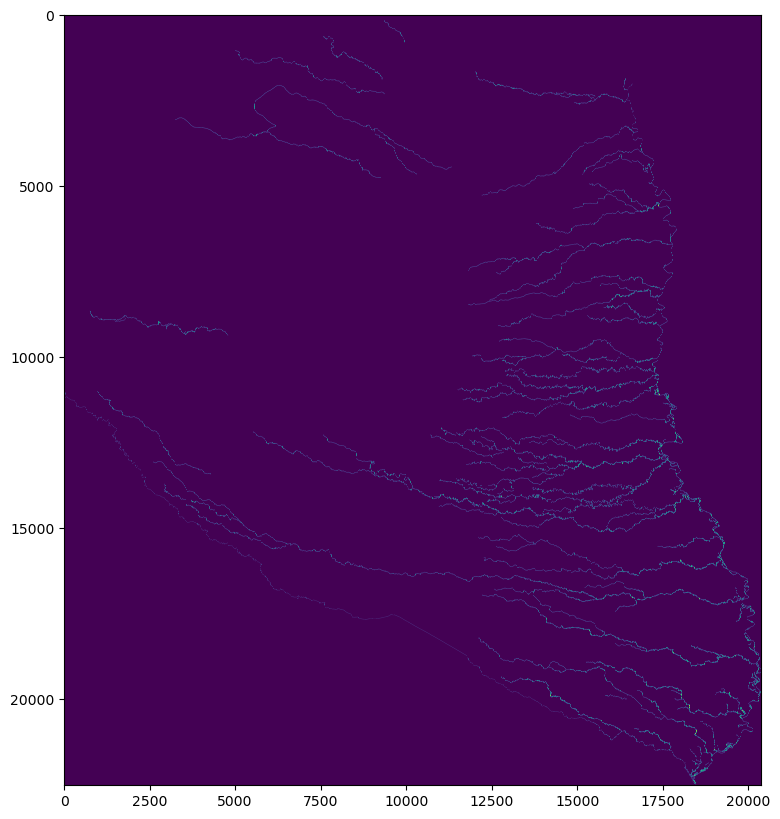

In [9]:
# Plot raster
fig, ax = plt.subplots(1, figsize = (10, 10))
show(rasterized_river, ax = ax)
plt.gca()

In [10]:
# Convert the rasterized array to boolean where True represents roads
river_mask = rasterized_river == 1

# Convert the lup_raster array to boolean where True represents the area of interest
area_mask = np.isin(lup_raster_array, [1, 2, 3, 4])

# Calculate the Euclidean distance from each road pixel to every other pixel
distances_river = distance_transform_edt(~river_mask)

# For pixels outside the area of interest, set the distance to a nodata value
distances_river[~area_mask] = -1


In [11]:
# Where files will save, can add subfolders if desired
output_dir = os.path.join(OUTPUT_PATH[0], 'processed_rasters', 'river_raster')
os.makedirs(output_dir, exist_ok=True)
output_filepath = os.path.join(output_dir, 'river_raster.tif')

In [12]:

# Write the rasterized data to a new GeoTIFF file
with rasterio.open(output_filepath, 'w', **profile) as dst:
    dst.write(distances_river.astype('float32'), 1)